# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Optionally correct for the geoid (important in low-gradient / low-lying areas)
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
# def remove_duplicates(a):
#     """
#     find unique rows in numpy array 
#     <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
#     """
#     b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
#     dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
#     return dedup

# coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
# shapeRecs = coast_shape.shapeRecords()
# coords = []
# for record in shapeRecs:
#     coords.append(record.shape.points[:])
    
# coords = np.vstack(coords)

# # Remove duplicates
# points = remove_duplicates(coords)

In [3]:
## Define region of interest (here Japan) 

japan_bounds = (125.0, 30.0, 155.0, 42.0)

aus_bounds = (110, -45, 160, -10)

minX, minY, maxX, maxY = japan_bounds




In [4]:
xres = 1000
yres = 1000

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T

In [5]:
# gtiff = gdal.Open("../../data/ETOPO1_Ice_c_geotiff.tif")
gtiff = gdal.Open("/home/student.unimelb.edu.au/nengl/Codes/ETOPO1_Ice_c_geotiff.tif")
width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

# plt.imshow(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

In [6]:
# np.savez_compressed("ETOPO.npz", Description="Etopo1 Numpy Array 21600 x 10800", ETOPO1=img)



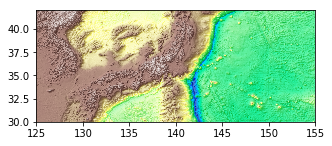

In [7]:
fig = plt.figure(1, figsize=(5,4))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
plt.show()

In [8]:
coords =np.stack((y1, x1)).T
coords2 =np.stack((y1, x1))

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX
im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]
 

In [9]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest').astype(np.float)

# Fake geoid for this particular region
# meshheights -= 40.0 * (y1 - minY) / (maxY - minY)

In [10]:
## Filter out the points we don't want at all 

points = meshheights > -500 

m1s = meshheights[points]
x1s = x1[points]
y1s = y1[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

/home/student.unimelb.edu.au/nengl/.local/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


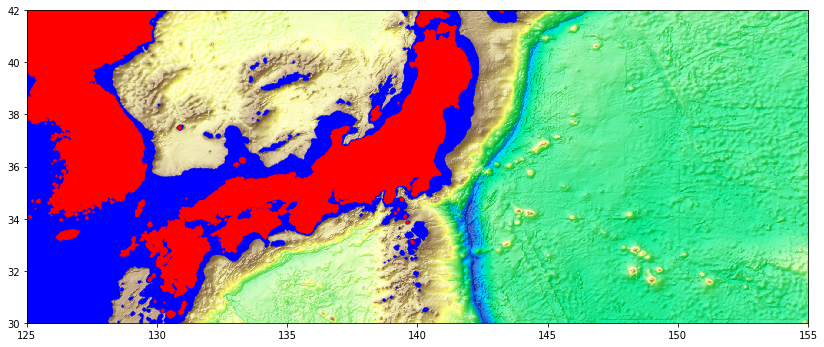

In [11]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[subaerial], y1s[subaerial], s=1.0, color="Red")

fig.show()

In [12]:
## triangulate

import stripy

mesh0 = stripy.cartesian.Triangulation(x1s, y1s, permute=True, tree=True)

## I think we only need the tree, not the triangulation

In [13]:
d, n = mesh0.nearest_vertices(mesh0.points[submarine][:,0], mesh0.points[submarine][:,1], k=25)

candidates = np.where(np.any(subaerial[n],axis=1))
keepers = n[candidates,0]


In [14]:
boundary = np.zeros_like(subaerial)
boundary[keepers] = True

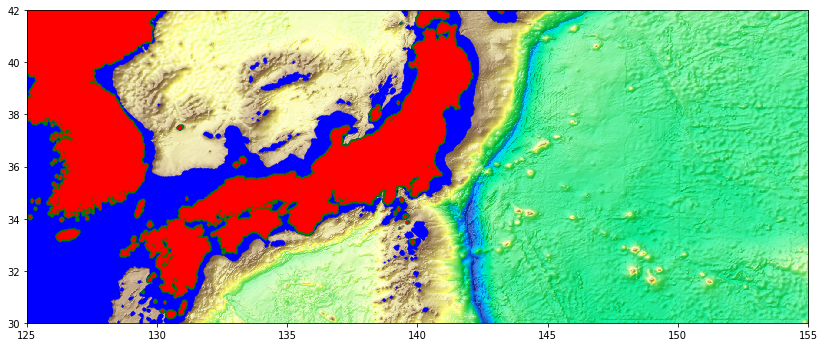

In [15]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')

ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[boundary],  y1s[boundary],  s=0.5, color="Green")
ax.scatter(x1s[subaerial], y1s[subaerial], s=0.25, color="Red")

fig.show()

In [16]:
x2s = x1s[subaerial | boundary]
y2s = y1s[subaerial | boundary]
bmask2 = subaerial[subaerial | boundary]

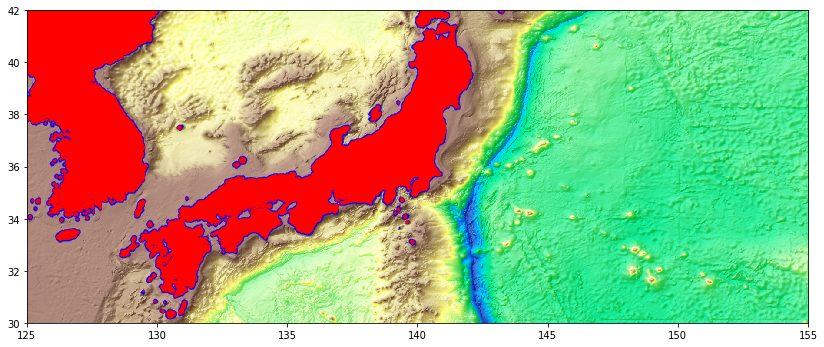

In [17]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')

ax.scatter(x2s[~bmask2],  y2s[~bmask2],  s=0.5, color="blue")
ax.scatter(x2s[ bmask2],  y2s[ bmask2], s=1.0, color="Red")

fig.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [18]:
DM = meshtools.create_DMPlex_from_points(x2s, y2s, bmask2, refinement_steps=0)


In [19]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True, permute=True)

0 - Delaunay triangulation 1.050688s
0 - Calculate node weights and area 0.017447s
0 - Find boundaries 0.006132s
0 - cKDTree 0.027969s
0 - Construct neighbour cloud array 0.916546s
0 - Construct rbf weights 0.136603s


In [20]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [21]:
## Now re-do the allocation of points to the surface.
## In parallel this will be done process by process for a sub-set of points

coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [22]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = mesh.rbf_smoother(meshheights, iterations=2)

raw_height = meshheights.copy() * 0.001

# meshheights -= 40.0 * (y2r - minY) / (maxY - minY)

In [23]:
subaerial =  meshheights >= -0.02
submarine = ~subaerial
mesh.bmask = subaerial

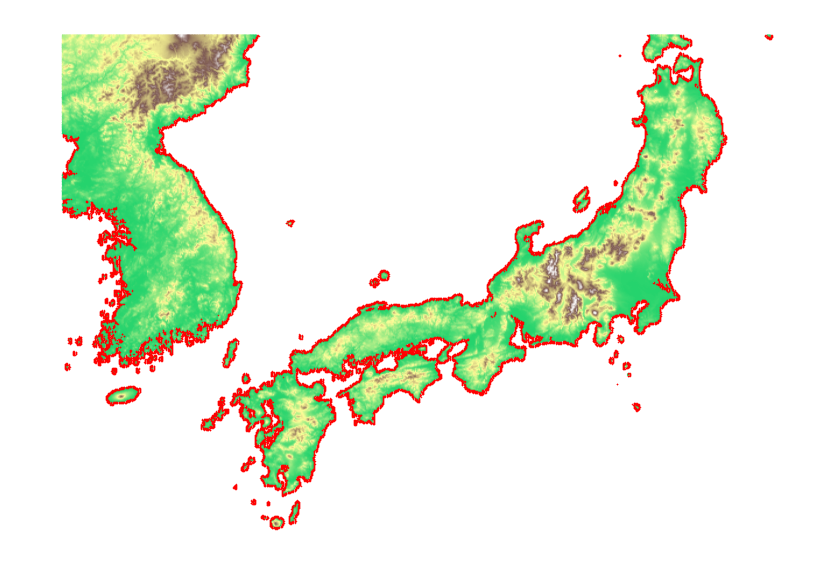

In [24]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[subaerial], y2r[subaerial], s=0.5,  c=meshheights[subaerial], cmap=cm.terrain, vmin=-1000.0, vmax=2500)
sc = ax.scatter(x2r[submarine], y2r[submarine], s=0.25, c="Red", alpha=1.0)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
fig.show()

In [25]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))  

raw_heights = mesh.height.copy()

0 - Compute slopes 2.229823s
0 - Build downhill matrices 0.45983s
mean gradient 4.042948246
number of flat spots 648
number of low points 1202


In [ ]:
its, flowpaths1 = mesh.cumulative_flow_verbose(mesh.area, verbose=True)
flowpaths1 = mesh.rbf_smoother(flowpaths1)

0: Max Delta - 8.04545786183 
10: Max Delta - 0.00517603103525 
20: Max Delta - 0.00210290659125 
30: Max Delta - 0.00180423205111 
40: Max Delta - 0.00112010177875 
50: Max Delta - 0.00142181474357 
60: Max Delta - 0.00170233782392 
70: Max Delta - 0.0005881465584 
80: Max Delta - 1.64644359956e-05 


## Low-point -filling algorithm

Most effective seems to be a little local patching followed by some iterations of the swamp fill. Repeat as necessary and check periodically to see what is actually happening.

In [ ]:
## Local

new_heights=mesh.low_points_local_patch_fill(its=2)
mesh._update_height_partial(new_heights)
low_points2 = mesh.identify_low_points()
print low_points2.shape

## Flooding

for i in range(0,20):
    new_heights = mesh.low_points_swamp_fill(ref_height=-0.02)
    mesh._update_height_partial(new_heights)
    low_points2 = mesh.identify_low_points()
    if low_points2.shape[0] == 0:
        break # Careful - not parallel !
    print low_points2.shape

Low point local patch fill
 - Partial rebuild of downhill matrices 0.373154s
 - Partial rebuild of downhill matrices 0.323193s
Low point local patch fill  0.899469  seconds
 - Partial rebuild of downhill matrices 0.329371s
(796,)
57  iterations, time =  0.926431
Build low point catchments -  0.927493  seconds
0  Sort spills -  0.016316
0  Gather spill data -  0.000291999999998
0  Sort all spills -  0.000623999999998
 - Partial rebuild of downhill matrices 0.303439s
Low point swamp fill  1.456834  seconds
 - Partial rebuild of downhill matrices 0.305905s
(181,)
94  iterations, time =  1.542162
Build low point catchments -  1.543805  seconds
0  Sort spills -  0.022175
0  Gather spill data -  0.000191000000001
0  Sort all spills -  0.000157999999999
 - Partial rebuild of downhill matrices 0.307232s
Low point swamp fill  2.068236  seconds
 - Partial rebuild of downhill matrices 0.315434s
(46,)
95  iterations, time =  1.573324
Build low point catchments -  1.574218  seconds
0  Sort spills -

In [ ]:
mesh.update_height(new_heights)
lakes = mesh.height - raw_heights
# lakes[~mesh.bmask] = 0.0

print lakes.max(), mesh.height.max(), mesh.height.min()

In [ ]:
its, flowpaths = mesh.cumulative_flow_verbose(np.ones_like(mesh.height), verbose=True)
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

In [ ]:
## Plane at zero height for visualization

minx = mesh.tri.x.min()
miny = mesh.tri.y.min()
maxx = mesh.tri.x.max()
maxy = mesh.tri.y.max()
refheight = -0.0005

bplanexy = np.array([ (minx, miny, refheight), 
                      (minx, maxy, refheight), 
                      (maxx, maxy, refheight), 
                      (maxx, miny, refheight)])

bplane_tri = [ (0, 1, 2), (0, 2, 3)]



In [ ]:
flowpaths1a = flowpaths1.copy()
flowpaths1a[mesh.height < 0.0] = 0.00001

flowpaths2a = flowpaths2.copy()
flowpaths2a[mesh.height < 0.0] = 0.00001


In [ ]:
manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=raw_heights*0.1, axis=1)

import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1500,1000], near=-10.0)


topo  = lv.triangles("topography",  wireframe=False)
topo.vertices(manifold)
topo.indices(mesh.tri.simplices)
topo.values(raw_heights, 'topography')
topo["zmin"] = -0.05

topo.colourmap("(-1.0)#FFFFFF:1.0 (-0.01)#0099FF:1.0 (0.01)#AAAAAA:1.0 (0.5)#777777:1.0 (2.5)#555555:1.0" , logscale=False)   # Apply a built in colourmap


topo2  = lv.triangles("topography2",  wireframe=False)
topo2.vertices(manifold)
topo2.indices(mesh.tri.simplices)
topo2.values(mesh.height, 'topography')
topo2["zmin"] = -0.05

topo2.colourmap("(-1.0)#FFFFFF:0.0 (-0.01)#0099FF:0.3 (0.01)#FFFF99:1.0 (0.5)#33AA11:1.0 (2.5)#886644:1.0" , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap

manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height*0.1, axis=1)


flowpath2 = lv.triangles("flow",  wireframe=False)
flowpath2.vertices(manifold+(0.0,0.0,0.02))
flowpath2.indices(mesh.tri.simplices)
flowpath2.values(flowpaths1a, label='flow1')
flowpath2.values(flowpaths2a, label='flow2')
flowpath2["zmin"] = -0.05
flowpath2.colourmap(["#FFFFFF:0.0 #0033FF:0.3 #000033"], logscale=True)   

## LAKES / SWAMPS

lakeheight = lakes.copy()
lakeheight[lakes > 0.0]  = mesh.height[lakes > 0.0]
lakeheight[lakes <= 0.0] = 0.0 # raw_heights[lakes <= 0.0] - 0.1

# manifold = np.reshape(mesh.coords, (-1,2))
# manifold = np.insert(manifold, 2, values=lakeheight*0.25, axis=1)

# lakeheight[lakes <= 0.0] = 0.0

lakeview = lv.triangles("lakes",  wireframe=False, colour="#00FFEE:0.5")
lakeview.vertices(manifold+(0.0,0.0,-0.002))
lakeview.indices(mesh.tri.simplices)
lakeview.values(lakeheight, 'lakes')
lakeview["zmin"] = -0.05

# lakeview.colourmap("(-1.0)#FFFFFF:0.0 (0.0)#FFFFFF:0.5 (0.05)#55FFEE:1.0 (1.0)#00FFEE:1.0" , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap

bplane = lv.triangles('bplane', wireframe=False, colour=(0.5,0.7,0.9,1.0))
bplane.vertices(bplanexy)
bplane.indices(bplane_tri)



In [ ]:

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Panel()
lv.control.Checkbox(property='axis')
flowpath2.control.List(["flow1", "flow2"], property="colourby", value="flow2", command="reload")
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

In [ ]:
lv.display()

In [ ]:
# 99 = 1

In [ ]:
manifold = np.reshape(mesh.coords[mesh.bmask], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[mesh.bmask]*0.25, axis=1)


In [ ]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')


# topo3 = lv.points(pointsize=2.0, pointtype=0)
# topo3.vertices(manifold+(0.0,0.0,0.1))
# # topo.values(mesh.height, label='height')
# topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

pass




In [ ]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

In [ ]:
lv.display()

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [ ]:
# 

In [ ]:
outflows = mesh.identify_outflow_points()
print("Mesh has {} outflows".format(outflows.shape[0]))
print outflows

In [ ]:
import lavavu

outpoints = np.column_stack([mesh.tri.points[outflows], mesh.height[outflows]])
points = np.column_stack([mesh.tri.points, mesh.height])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=5.0, pointtype="shiny", colour="#FF0000" )
# nodes.vertices(low_points)
nodes.vertices(outpoints)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow1')

topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

lv.window()
# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.display()